In [7]:
import tensorflow_datasets as tfds

# Load the dataset
dataset, info = tfds.load('malaria', as_supervised=True, with_info=True)

In [8]:
# Dataset informations
print('Dataset name:', info.name)
print('Dataset description:', info.description)
print('Dataset version:', info.version)
print('Dataset features:', info.features)
print('Dataset splits:', info.splits)
print('Number of train examples:', info.splits['train'].num_examples)
print('Dataset size:', info.splits['train'].num_examples)
print('Number of classes:', info.features['label'].num_classes)
print('Class names:', info.features['label'].names)
print('Image shape:', info.features['image'].shape)
print('Label type:', info.features['label'].np_dtype)  # Updated to use np_dtype

Dataset name: malaria
Dataset description: The Malaria dataset contains a total of 27,558 cell images with equal instances
of parasitized and uninfected cells from the thin blood smear slide images of
segmented cells.
Dataset version: 1.0.0
Dataset features: FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
Dataset splits: {'train': <SplitInfo num_examples=27558, num_shards=4>}
Number of train examples: 27558
Dataset size: 27558
Number of classes: 2
Class names: ['parasitized', 'uninfected']
Image shape: (None, None, 3)
Label type: <class 'numpy.int64'>


In [9]:
# Extraire uniquement les données
full_data = dataset['train']

# Obtenir le nombre total d'échantillons
total_examples = info.splits['train'].num_examples

# Définir les ratios
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Calculer les tailles des ensembles
train_size = int(total_examples * train_split)
val_size = int(total_examples * val_split)
test_size = total_examples - train_size - val_size  # Le reste pour le test

In [10]:
# Mélanger les données pour un découpage aléatoire
shuffled_data = full_data.shuffle(total_examples, seed=42)

# Fractionner les ensembles
train_data = shuffled_data.take(train_size)  # Prendre les premiers `train_size` échantillons
remaining_data = shuffled_data.skip(train_size)  # Passer les échantillons d'entraînement

val_data = remaining_data.take(val_size)  # Prendre les `val_size` suivants
test_data = remaining_data.skip(val_size)  # Le reste pour le test

# Informations sur les datasets
print(train_data)
print(test_data)
print(val_data)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Images Train Datas


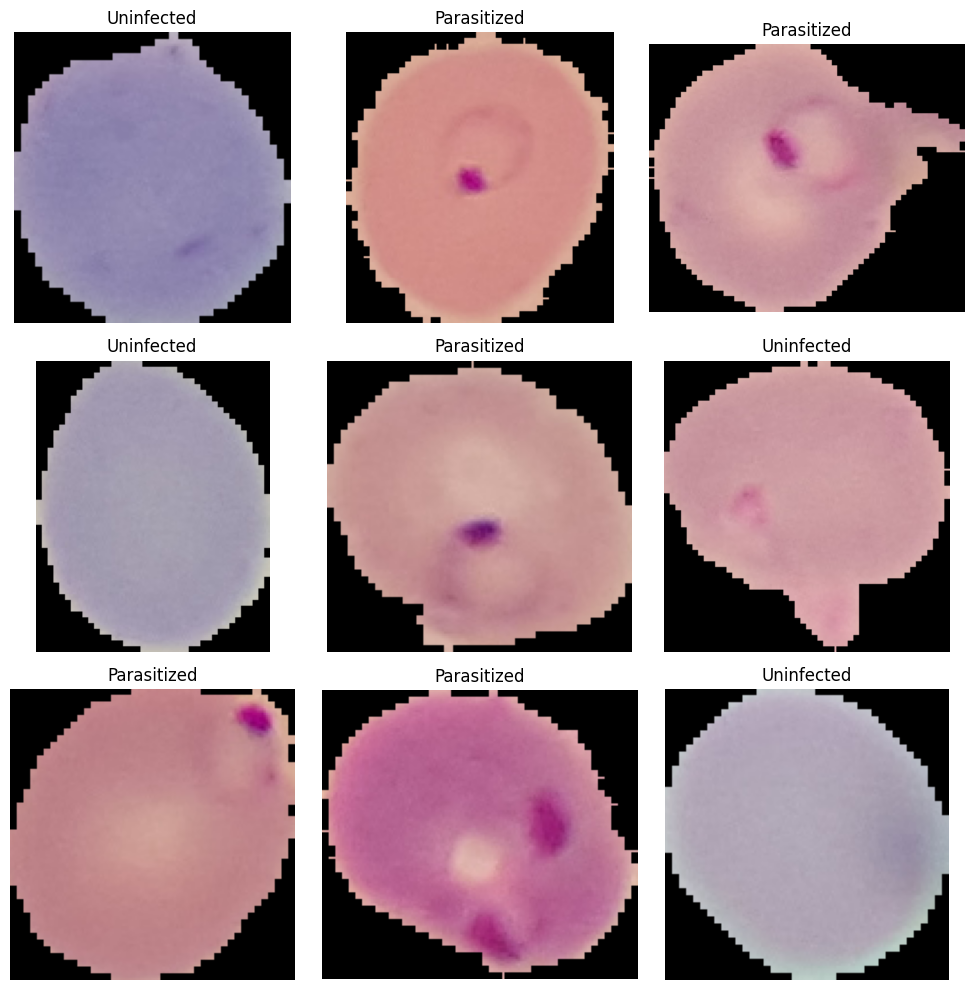

Images Test Datas


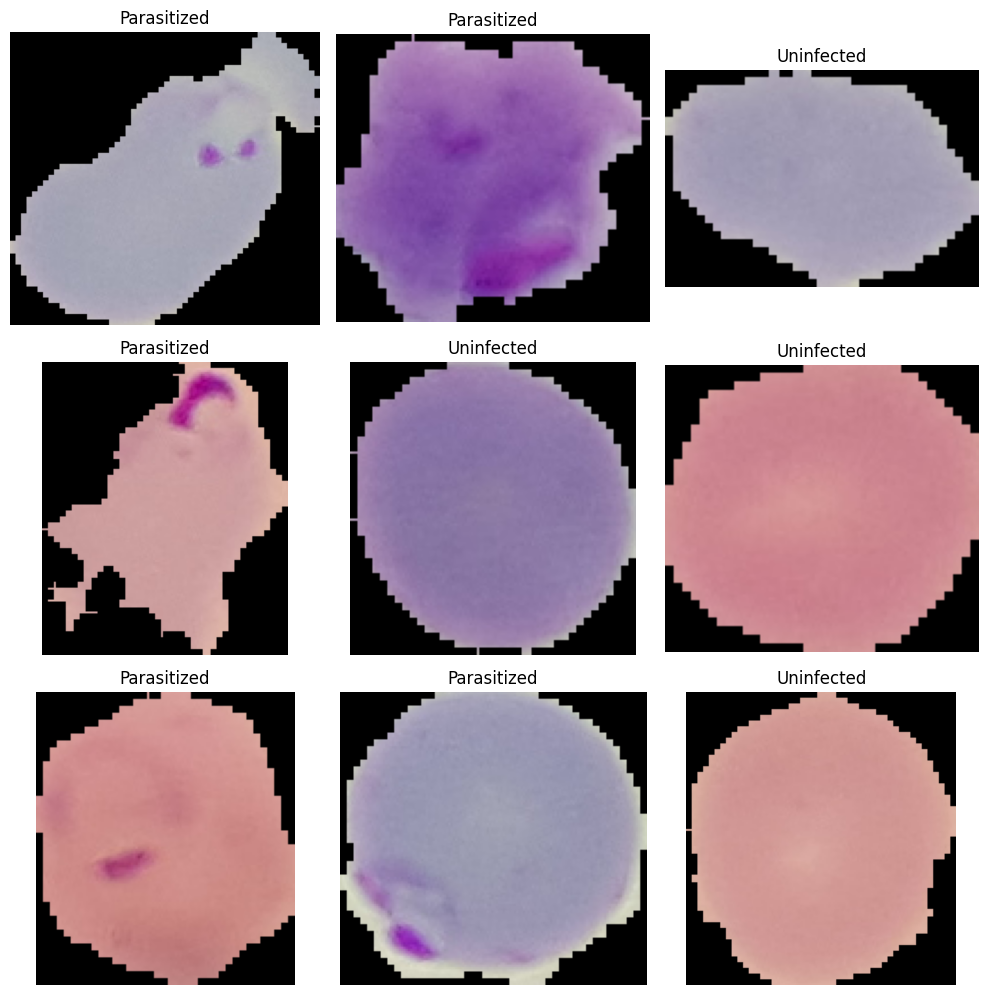

Images Validation Datas


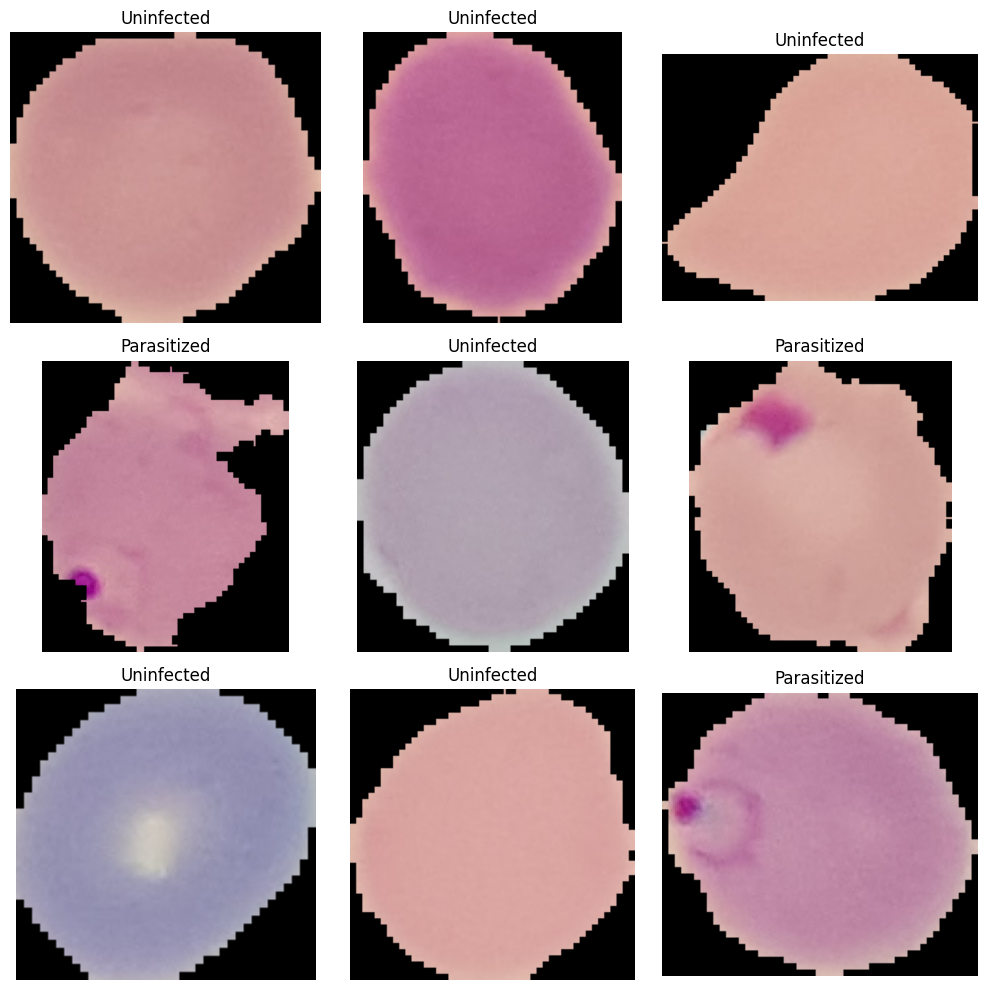

In [11]:
import matplotlib.pyplot as plt

# Classes : 0 -> Parasitized, 1 -> Uninfected
class_names = ['Parasitized', 'Uninfected']

# Fonction pour afficher une grille d'images
def display_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Convertir TensorFlow Tensors en NumPy pour l'affichage
        image = image.numpy()
        label = label.numpy()
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Appeler la fonction
print("Images Train Datas")
display_images(train_data)
print("Images Test Datas")
display_images(test_data)
print("Images Validation Datas")
display_images(val_data)

In [12]:
import tensorflow as tf
# Fonction pour encoder les labels en binaire
def encode_labels_binary(image, label):
    # Vérifier si le label est déjà binaire (0 ou 1), sinon le convertir
    # (Cela suppose que les labels sont déjà dans un format binaire ou que vous souhaitez les convertir)
    label = tf.cast(label, tf.int32)  # Assurer que les labels sont dans un format entier (0 ou 1)
    return image, label

# Appliquer la conversion one-hot aux données
train_data = train_data.map(encode_labels_binary)
val_data = val_data.map(encode_labels_binary)
test_data = test_data.map(encode_labels_binary)

In [13]:
import tensorflow as tf
# Fonction de prétraitement
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Redimensionner les images
    image = tf.cast(image, tf.float32) / 255.0  # Normaliser les pixels entre 0 et 1
    return image, label

# Appliquer le prétraitement et créer des batches
batch_size = 32

train_data = (train_data
              .map(preprocess)
              .shuffle(1000)  # Mélanger après découpage
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_data
            .map(preprocess)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

test_data = (test_data
             .map(preprocess)
             .batch(batch_size)
             .prefetch(tf.data.AUTOTUNE))

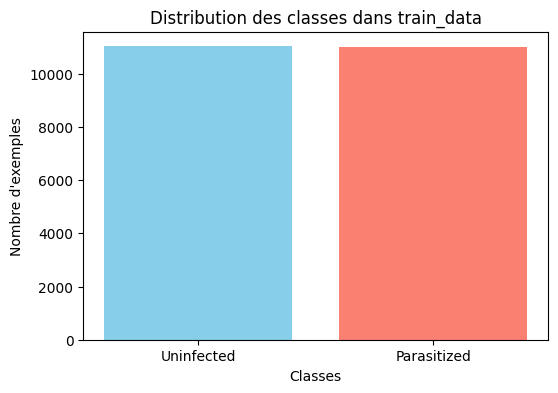

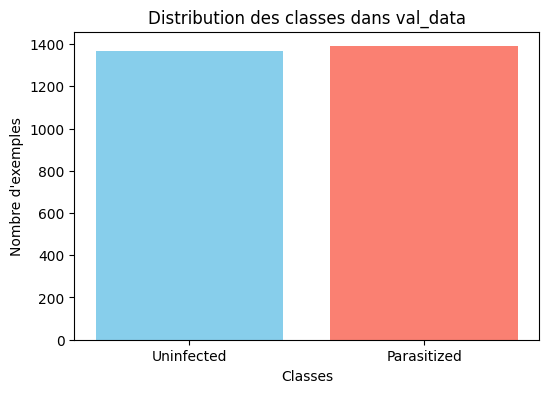

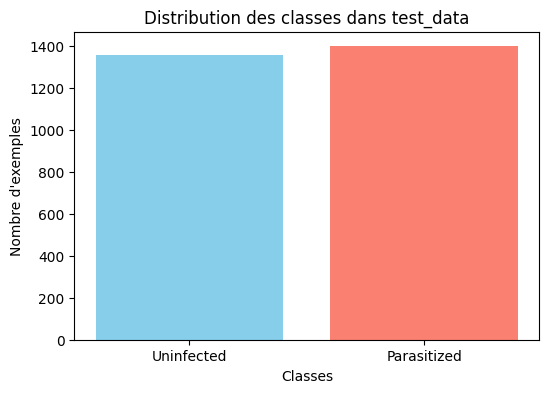

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(data, dataset_name):
    # Extraire les labels des données
    labels = np.concatenate([y for _, y in data], axis=0)

    # Si les labels sont déjà binaires (0 ou 1), aucun besoin de les convertir
    # Comptage des occurrences de chaque classe
    unique, counts = np.unique(labels, return_counts=True)

    # Visualisation
    plt.figure(figsize=(6, 4))
    plt.bar(unique, counts, tick_label=['Uninfected', 'Parasitized'], color=['skyblue', 'salmon'])
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'exemples')
    plt.title(f'Distribution des classes dans {dataset_name}')
    plt.show()

# Visualisation de la distribution des classes pour chaque dataset
plot_class_distribution(train_data, 'train_data')
plot_class_distribution(val_data, 'val_data')
plot_class_distribution(test_data, 'test_data')


In [15]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Définir un modèle CNN
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Deux sorties pour one-hot encoded
])

In [16]:
from tensorflow.keras.optimizers import Adam

# Définir l'optimiseur
optimizer = Adam(learning_rate=0.001)
# Compiler le modèle
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
# Afficher un résumé du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True,  # Récupère les poids du meilleur modèle
    verbose=1
)

In [19]:
# Entraîner le modèle
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 123ms/step - accuracy: 0.5327 - loss: 1.1911 - val_accuracy: 0.5002 - val_loss: 0.7513
Epoch 2/30
111/689 ━━━━━━━━━━━━━━━━━━━━ 1:04 112ms/step - accuracy: 0.5639 - loss: 0.7414

KeyboardInterrupt: 

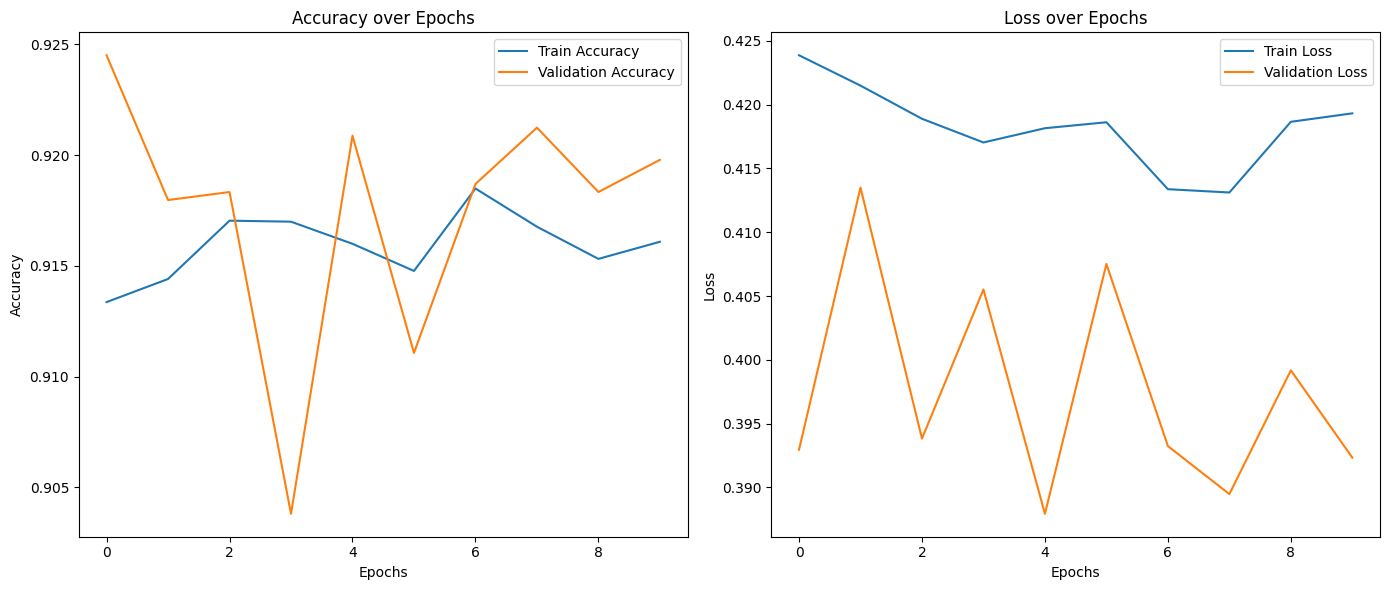

In [20]:
import matplotlib.pyplot as plt

# Fonction pour afficher les courbes
def plot_history(history):
    # Création d'une figure avec 2 sous-graphiques côte à côte
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Courbe de précision
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].legend()

    # Courbe de perte
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss over Epochs')
    axs[1].legend()

    # Afficher les graphes
    plt.tight_layout()
    plt.show()

# Appel de la fonction pour afficher les courbes
plot_history(history)

In [35]:
# Évaluer les performances sur le jeu de test
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9868 - loss: 0.0432
Test Accuracy: 0.99


87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


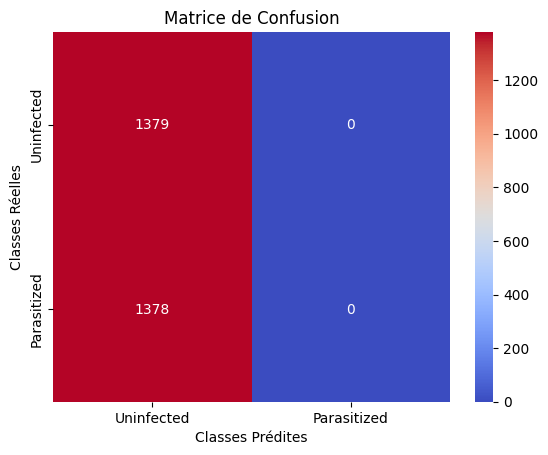

Rapport de classification :
              precision    recall  f1-score   support

  Uninfected       0.50      1.00      0.67      1379
 Parasitized       0.00      0.00      0.00      1378

    accuracy                           0.50      2757
   macro avg       0.25      0.50      0.33      2757
weighted avg       0.25      0.50      0.33      2757



C:\Users\Utilisateur\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Utilisateur\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Utilisateur\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prédictions sur l'ensemble de test
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtenir les classes prédites

# Extraire les labels réels (pas one-hot)
y_true = np.concatenate([y for _, y in test_data], axis=0)  # Récupérer les labels réels
y_true_classes = np.argmax(y_true, axis=1)  # Convertir les labels one-hot en indices

# Créer une heatmap de la matrice de confusion
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Affichage de la matrice de confusion avec des annotations
sns.heatmap(conf_matrix, annot=True, cmap="coolwarm", fmt="d",
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])

plt.title("Matrice de Confusion")
plt.xlabel("Classes Prédites")
plt.ylabel("Classes Réelles")
plt.show()

# Rapport de classification
class_report = classification_report(y_true_classes, y_pred_classes, target_names=['Uninfected', 'Parasitized'])
print("Rapport de classification :")
print(class_report)